In [2]:
import numpy as np
from scipy.stats import bernoulli
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Takes a list of n bits and produces degree*n bits, `degree' bits produced by broadcast process from each input bit 
def expandArrayFast(L,degree,eps):
    A = np.zeros((len(L),degree))
    for j in range(0,degree):
        biased_bits = bernoulli.rvs(0.5+eps,size=len(L))
        A[:,j] = biased_bits * L + (1-biased_bits)*(1-L)
    return A.flatten()

# Applies expandArrayFast recursively depth times, takes a list L of n bits and produces all leaves of depth trees 
# starting from each bit separately.
def expandTreeFast(L,depth,degree,eps):
    prevL = L
    for i in range(0,depth):
        currentL = expandArrayFast(prevL,degree,eps)
        prevL    = currentL
    return prevL

# Takes a list L of n*degree numbers, produces n numbers by applying local Bayes 
def contractArrayFast(L,degree,eps):
    M = np.reshape(L,(-1,degree))
    #weights1 = [(0.5+eps)*a + (0.5-eps)*(1 - a) for a in P]
    weights1 = (0.5 - eps) + 2*eps*M
    #weights0 = [(0.5-eps)*a + (0.5+eps)*(1 - a) for a in P]
    weights2 = 1.0- weights1    
    #w1 = np.prod(weights1)
    w1 = np.prod(weights1,axis=1)
    #w0 = np.prod(weights0)
    w0 = np.prod(weights2,axis=1)
    #z = w1 + w0
    z = w1 + w0
    return w1/z

# Applies contract Array recursively
def contractTreeFast(L,depth,degree,eps):
    prevL = L
    for i in range(0,depth):
        currentL = contractArrayFast(prevL,degree,eps)
        prevL    = currentL
    return prevL

# Compute empirical distribution
def get_empirical_dist(numTrials,depth,degree,eps):
    blockSize = 50
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        leafSigns = expandTreeFast(rootList,depth,degree,eps)
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafSigns,depth,degree,eps)))
    return emp_dist

# testing fixed-point ness
def test_Fixed_Point(old_emp_dist,numTrials,depth,degree,eps):
    new_emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = expandTreeFast(rootList,depth,degree,eps)
        #   Creating leaf Biases by randomly choosing from old empirical distribution
        leafBias = np.random.choice(old_emp_dist,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        new_emp_dist = np.concatenate((new_emp_dist,contractTreeFast(leafMessages,depth,degree,eps)))
    return new_emp_dist

# testing universality
def test_Universality(marginals,numTrials,depth,degree,eps):
    new_emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = expandTreeFast(rootList,depth,degree,eps)
        #   Creating leaf Biases by randomly choosing from old empirical distribution
        leafBias = np.random.choice(marginals,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        new_emp_dist = np.concatenate((new_emp_dist,contractTreeFast(leafMessages,depth,degree,eps)))
    return new_emp_dist

# Fix the marginals, but vary the broadcast to plot the histogram
def test_Fix_Marginals(marginals,numTrials,depth,degree,eps):
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = (expandTreeFast(rootList,depth,degree,eps)).reshape((blockSize,-1))
        #   Copying marginals again and again
        leafBias = marginals
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafMessages.flatten(),depth,degree,eps)))
    return emp_dist    

def mymain():
    
    print("Computing Emprical Distribution:")
    theta = get_empirical_dist(numTrials,depth,degree,eps)
    mean_theta = np.mean(theta)
    sigma_theta = np.var(theta)
    print("Empirical Distribution Mean:",np.mean(theta))
    print("Empirical Distribution Variance:",np.sqrt(np.var(theta)))
    plt.hist(theta,50)
    
    print("Testing Fixed-pointness:")
    new_theta = test_Fixed_Point(theta,numTrials,depth,degree,eps)
    print("New empirical Distribution Mean:",np.mean(new_theta))
    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
    plt.hist(new_theta,50)

#    print("Testing Universality with Gaussian inputs:")
#    marginals = np.random.normal(mean_theta,sigma_theta,numTrials)
#    new_theta = test_Universality(marginals,numTrials,depth,degree,eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)

#    print("Testing Chaos:")
    #Changing mean and variance arbitrarily
#    marginals = np.random.normal(mean_theta,sigma_theta/100.0,numTrials)
#    new_theta = test_Universality(marginals,numTrials,depth,degree,eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)

    print("Testing Fixed Marginals, varying broadcast:")
    # Gaussian marginals with small variance
    # marginals = np.random.normal(mean_theta,sigma_theta/100.0,degree**depth)
    # All marginals fixed to mean
    marginals = np.full(degree**depth, mean_theta)
    print("marginals length =", len(marginals))
    new_theta = test_Fix_Marginals(marginals,numTrials,depth,degree,eps)
    print("New empirical Distribution Mean:",np.mean(new_theta)-0.2)
    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
    plt.hist(new_theta,50)
    
    return

    
blockSize = 100
numTrials = 10000
depth     = 6
degree    = 3
eps       = 0.30
    

Computing Emprical Distribution:
Empirical Distribution Mean: 0.6378596111886324
Empirical Distribution Variance: 0.22475577812169603
Testing Fixed-pointness:
New empirical Distribution Mean: 0.593338969499866
New Empirical Distribution Variance: 0.1960642638330865
Testing Fixed Marginals, varying broadcast:
marginals length = 729
New empirical Distribution Mean: 0.419558553013138
New Empirical Distribution Variance: 0.19288561300262702


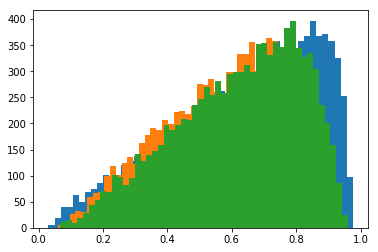

In [30]:
mymain()